In [1]:
#Prediction of cyclonic and anticyclonic simulated eddies - December 2021
import sklearn
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as MSE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from joblib import load
from keras import backend as K
import xarray as xr
import numpy as np
import pandas as pd
import time
from pathlib import Path
import gsw
import glob
from numba import float64, guvectorize

import matplotlib.pyplot as plt
import cmocean

path_ds = '/home/datawork-lops-bluecloud/osnet/data_remote_sensing/Gridded_input_9319.nc'
path_models = '/home/datawork-lops-bluecloud/osnet/models/exp1_TS'
path_out = '/home/datawork-lops-bluecloud/osnet/product_out/Eddy_synthetic_TS'
pathfig = '/home1/datawork/epauthen/Fig_Product/Figure_clean/'

Path(path_out).mkdir(parents=True, exist_ok=True)

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config["data_dir"] = '../cartopy_shapefiles'


# core functions

In [2]:
def get_mean_std_pred(ensemble, X, ds, Sm, Sstd, Tm, Tstd):
    predS = []
    predT = []
    mld = []
    for model in ensemble:
        tmp_pred = model.predict(X)
        temp = tmp_pred[:, :, 1] * Tstd + Tm
        psal = tmp_pred[:, :, 0] * Sstd + Sm
        predS.append(psal)
        predT.append(temp)
        mld.append(tmp_pred[:, :, 2])
    return np.mean(predS, axis=0), np.std(predS, axis=0), np.mean(predT, axis=0), np.std(predT, axis=0), np.mean(mld, axis=0)


def get_MLD_from_mask(mask):
    depth_levels = [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 19, 22, 26, 30, 35, 40, 45, 50, 55,
                    60, 65, 70, 75, 80, 90, 100, 110, 120, 133, 147, 163, 180, 199, 221, 245, 271,
                    301, 334, 371, 412, 458, 509, 565, 628, 697, 773, 857, 950, 1000]
    mask = np.sign(0.5 - mask)
    return depth_levels[np.argmin(mask)]


def add_sig(ds):
    SA = gsw.SA_from_SP(ds['PSAL_predicted'], ds['PRES_INTERPOLATED'], ds['lon'], ds['lat'])
    CT = gsw.CT_from_t(ds['PSAL_predicted'], ds['TEMP_predicted'], ds['PRES_INTERPOLATED'])
    sig = gsw.sigma0(SA, CT)
    ds = ds.assign(variables={"SIG_predicted": (('lat', 'PRES_INTERPOLATED'), sig.data)})
    return ds


def predict_month(x, ensemble, scal_Sm, scal_Sstd, scal_Tm, scal_Tstd, scaler_input, path_out, suffix):
    # ----------- create X vector --------------- #
    d = 1/365
    cos_week = np.cos(np.pi * 2 * d * x['dayOfYear'].data)
    sin_week = np.sin(np.pi * 2 * d * x['dayOfYear'].data)
    X = np.zeros([len(x['lat']), 12])
    X[:,0] = x['SLA'].data
    X[:,1] = x['lat'].data
    X[:,2] = x['lon'].data
    X[:,3] = cos_week
    X[:,4] = sin_week
    X[:,5] = x['MDT'].data
    X[:,6] = x['UGOSA'].data
    X[:,7] = x['VGOSA'].data
    X[:,8] = x['UGOS'].data
    X[:,9] = x['VGOS'].data
    X[:,10] = x['SST'].data
    X[:,11] = -x['BATHY'].data

    X_scaled = scaler_input.transform(X)

    # ------------- Predict and add to dataset -------------- #
    get_MLD_from_mask_vect = np.vectorize(get_MLD_from_mask, signature='(k)->()')
    pred_S_mean, pred_S_std, pred_T_mean, pred_T_std, mld = get_mean_std_pred(ensemble, X_scaled, x, scal_Sm, scal_Sstd, scal_Tm, scal_Tstd)
    x = x.assign(variables={"PSAL_predicted": (('lat', 'PRES_INTERPOLATED'), pred_S_mean.data)})
    x = x.assign(variables={"TEMP_predicted": (('lat', 'PRES_INTERPOLATED'), pred_T_mean.data)})
    x = x.assign(variables={"MLD_mask": (('lat', 'PRES_INTERPOLATED'), mld.data)})
    x = x.assign(variables={"MLD_pred": (('lat'), get_MLD_from_mask_vect(x.MLD_mask))})
    x = x.assign(variables={"PSAL_predicted_std": (('lat', 'PRES_INTERPOLATED'), pred_S_std.data)})
    x = x.assign(variables={"TEMP_predicted_std": (('lat', 'PRES_INTERPOLATED'), pred_T_std.data)})
    x = add_sig(x)
    
    x.to_netcdf(f"{path_out}/Synthetic{suffix}.nc")
    print(f"size output file: {np.around(x.nbytes / 1073741824,2)} Go, saved in {path_out}/Synthetic{suffix}.nc")

# load models

In [3]:
#Load scalers
scaler_input = load(f"{path_models}/scaler_input.joblib")
scaler_input = load(f"{path_models}/scaler_input.joblib")
scal_Sm = load(f'{path_models}/Sm.joblib')
scal_Sstd = load(f'{path_models}/Sstd.joblib')
scal_Tm = load(f'{path_models}/Tm.joblib')
scal_Tstd = load(f'{path_models}/Tstd.joblib')

In [4]:
%%time
#Load models
models_list = glob.glob(f'{path_models}/neuralnet/ensemble/*')
ensemble = []
for model_path in models_list:
    ensemble.append(keras.models.load_model(model_path, compile=False))

CPU times: user 5.19 s, sys: 276 ms, total: 5.46 s
Wall time: 6.94 s


# predict section

In [26]:
#Prepare input
ds = xr.open_dataset(f"{path_ds}")
# compute day of year
day = np.array(pd.DatetimeIndex(ds['time'].data).dayofyear).astype(np.int32)
ds = ds.assign(variables={"dayOfYear": (('time'), day)})
depth_levels = [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 19, 22, 26, 30, 35, 40,
            45, 50, 55, 60, 65, 70, 75, 80, 90, 100, 110, 120, 133, 147, 163,
            180, 199, 221, 245, 271, 301, 334, 371, 412, 458, 509, 565, 628,
            697, 773, 857, 950, 1000]
ds = ds.assign_coords(PRES_INTERPOLATED=depth_levels)
ds = ds.assign(variables={"SSH": (('time', 'lat', 'lon'), ds.SLA+ds.MDT)})
x = ds.sel(time = '2006-10-06',lon = -64,method = 'nearest')
x

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 51, lat: 108)
Coordinates:
  * lat                (lat) float32 23.12 23.38 23.62 ... 49.38 49.62 49.88
    lon                float32 -63.88
    time               datetime64[ns] 2006-10-06
    mask               (lat) float64 ...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 1 2 3 4 ... 773 857 950 1000
Data variables:
    SLA                (lat) float32 ...
    UGOS               (lat) float32 ...
    VGOS               (lat) float32 ...
    UGOSA              (lat) float32 ...
    VGOSA              (lat) float32 ...
    SLA_err            (lat) float32 ...
    BATHY              (lat) float32 ...
    MDT                (lat) float32 ...
    SST                (lat) float32 ...
    SST_uncertainty    (lat) float32 ...
    dayOfYear          int32 279
    SSH                (lat) float32 0.8839 0.8862 0.893 0.9006 ... nan nan nan

In [28]:
#Run prediction
time_start = time.time()
print(f'Starting prediction for a section')
predict_month(x=x, ensemble=ensemble, scal_Sm=scal_Sm, scal_Sstd=scal_Sstd, scal_Tm=scal_Tm,
                          scal_Tstd=scal_Tstd, scaler_input=scaler_input, path_out=path_out, suffix="_TS")
print(f"Computation finished in {np.around(time.time() - time_start,2)} secondes")

Starting prediction for a section
size output file: 0.0 Go, saved in /home/datawork-lops-bluecloud/osnet/product_out/Eddy_synthetic_TS/Synthetic_TS.nc
Computation finished in 0.53 secondes


# Predict benchmark with SLA at 0

In [29]:
#Create a new SLA that is flat
sla = np.zeros(len(x.SLA))
x = x.assign(variables={"SLA_ori": (('lat'), x.SLA.data)})
x = x.assign(variables={"SLA": (('lat'), sla)})

In [30]:
#Run prediction
time_start = time.time()
print(f'Starting prediction for a section')
predict_month(x=x, ensemble=ensemble, scal_Sm=scal_Sm, scal_Sstd=scal_Sstd, scal_Tm=scal_Tm,
                          scal_Tstd=scal_Tstd, scaler_input=scaler_input, path_out=path_out, suffix="_TS2")
print(f"Computation finished in {np.around(time.time() - time_start,2)} secondes")

Starting prediction for a section
size output file: 0.0 Go, saved in /home/datawork-lops-bluecloud/osnet/product_out/Eddy_synthetic_TS/Synthetic_TS2.nc
Computation finished in 0.53 secondes


# Compute the adjustment using mask

In [31]:
def add_maskv3(ds):
    #New mask for better surface reconstruction
    b = 2
    b2 = 1
    H = 0.528   #For exp1_TS
    mask2 = np.where(ds['MLD_mask'].data<H, ds['MLD_mask'], 1)
    ds = ds.assign(variables={"MLD_mask2": (('lat', 'PRES_INTERPOLATED'), mask2)})
    mask3 = np.where((ds['MLD_mask']>H) & (ds['MLD_mask']<b2), b-ds['MLD_mask'].data, ds['MLD_mask2'].data)
    ds = ds.assign(variables={"MLD_mask3": (('lat', 'PRES_INTERPOLATED'), mask3)})
    return ds


@guvectorize(
    "(float64[:], float64[:], float64[:], float64[:], float64[:], float64[:])",
    "(n), (n), (n), (n) -> (n), (n)"
)
def apply_mask_1d(temp_in, psal_in, depth, mask, temp, psal):
    temp[:] = np.copy(temp_in)
    psal[:] = np.copy(psal_in)
    for d in range(len(depth)-2, -1, -1):
        # apply mask on TEMP and PSAL
        temp[d] = (temp_in[d]*mask[d] - temp_in[d+1]*mask[d]) + temp[d+1]
        psal[d] = (psal_in[d]*mask[d] - psal_in[d+1]*mask[d]) + psal[d+1]

def post_processing_adjustment(ds,mask):
    temp_out, psal_out = xr.apply_ufunc(apply_mask_1d,
                                    ds['TEMP_predicted'], ds['PSAL_predicted'], ds['PRES_INTERPOLATED'], mask,
                                    input_core_dims=(['PRES_INTERPOLATED'],['PRES_INTERPOLATED'],['PRES_INTERPOLATED'],['PRES_INTERPOLATED']),
                                    output_core_dims=(['PRES_INTERPOLATED'],['PRES_INTERPOLATED']),
                                    output_dtypes=[np.float64, np.float64])
    # get sig adjusted
    sa_out = gsw.SA_from_SP(psal_out, ds['PRES_INTERPOLATED'], ds['lon'], ds['lat'])
    ct_out = gsw.CT_from_t(sa_out,temp_out,ds['PRES_INTERPOLATED'])
    sig_out = gsw.sigma0(sa_out, ct_out)
    
    ds_out = ds.assign(variables={"TEMP_adj": (('lat','PRES_INTERPOLATED'), temp_out.data),
                                  "PSAL_adj": (('lat','PRES_INTERPOLATED'), psal_out.data),
                                  "SIG_adj": (('lat','PRES_INTERPOLATED'), sig_out.data)})
    return ds_out 

## adjust section

In [32]:
%%time
sy = xr.open_dataset(f"{path_out}/Synthetic_TS.nc")
sy = add_maskv3(sy)
print(f'Starting adjustment for original section')
sy = post_processing_adjustment(sy, mask = sy['MLD_mask3'])
print(f"size output file: {np.around(sy.nbytes / 1073741824,2)} Go, saved in {path_out}/Synthetic_TS_adj.nc")
sy.to_netcdf(f"{path_out}/Synthetic_TS_adj.nc")
sy

Starting adjustment for original section
size output file: 0.0 Go, saved in /home/datawork-lops-bluecloud/osnet/product_out/Eddy_synthetic_TS/Synthetic_TS_adj.nc
CPU times: user 88 ms, sys: 0 ns, total: 88 ms
Wall time: 96.2 ms


<xarray.Dataset>
Dimensions:             (PRES_INTERPOLATED: 51, lat: 108)
Coordinates:
  * lat                 (lat) float32 23.12 23.38 23.62 ... 49.38 49.62 49.88
    lon                 float32 ...
    time                datetime64[ns] ...
    mask                (lat) float64 ...
  * PRES_INTERPOLATED   (PRES_INTERPOLATED) int64 0 1 2 3 4 ... 773 857 950 1000
Data variables: (12/24)
    SLA                 (lat) float32 ...
    UGOS                (lat) float32 ...
    VGOS                (lat) float32 ...
    UGOSA               (lat) float32 ...
    VGOSA               (lat) float32 ...
    SLA_err             (lat) float32 ...
    ...                  ...
    SIG_predicted       (lat, PRES_INTERPOLATED) float64 ...
    MLD_mask2           (lat, PRES_INTERPOLATED) float32 6.833e-05 ... 1.0
    MLD_mask3           (lat, PRES_INTERPOLATED) float32 6.833e-05 ... 1.0
    TEMP_adj            (lat, PRES_INTERPOLATED) float64 29.29 29.29 ... nan nan
    PSAL_adj            (lat, PRES_INTERPOLATED) float64 36.63 36.63 ... nan nan
    SIG_adj             (lat, PRES_INTERPOLATED) float64 23.19 23.19 ... nan nan

In [33]:
%%time
sy2 = xr.open_dataset(f"{path_out}/Synthetic_TS2.nc")
sy2 = add_maskv3(sy2)
print(f'Starting adjustment for original section')
sy2 = post_processing_adjustment(sy2, mask = sy2['MLD_mask3'])
print(f"size output file: {np.around(sy2.nbytes / 1073741824,4)} Go, saved in {path_out}/Synthetic_TS2_adj.nc")
sy2.to_netcdf(f"{path_out}/Synthetic_TS2_adj.nc")
sy2

Starting adjustment for original section
size output file: 0.0003 Go, saved in /home/datawork-lops-bluecloud/osnet/product_out/Eddy_synthetic_TS/Synthetic_TS2_adj.nc
CPU times: user 76 ms, sys: 12 ms, total: 88 ms
Wall time: 100 ms


<xarray.Dataset>
Dimensions:             (PRES_INTERPOLATED: 51, lat: 108)
Coordinates:
  * lat                 (lat) float32 23.12 23.38 23.62 ... 49.38 49.62 49.88
    lon                 float32 ...
    time                datetime64[ns] ...
    mask                (lat) float64 ...
  * PRES_INTERPOLATED   (PRES_INTERPOLATED) int64 0 1 2 3 4 ... 773 857 950 1000
Data variables: (12/25)
    SLA                 (lat) float64 ...
    UGOS                (lat) float32 ...
    VGOS                (lat) float32 ...
    UGOSA               (lat) float32 ...
    VGOSA               (lat) float32 ...
    SLA_err             (lat) float32 ...
    ...                  ...
    SIG_predicted       (lat, PRES_INTERPOLATED) float64 ...
    MLD_mask2           (lat, PRES_INTERPOLATED) float32 0.0001066 ... 1.0
    MLD_mask3           (lat, PRES_INTERPOLATED) float32 0.0001066 ... 1.0
    TEMP_adj            (lat, PRES_INTERPOLATED) float64 28.9 28.9 ... nan nan
    PSAL_adj            (lat, PRES_INTERPOLATED) float64 36.63 36.63 ... nan nan
    SIG_adj             (lat, PRES_INTERPOLATED) float64 23.32 23.32 ... nan nan

# Plot results

In [34]:
#Map of TS
proj=ccrs.PlateCarree()
land_feature = cfeature.NaturalEarthFeature(
category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
extent = np.array([-80, -30, 23, 47.5])
subplot_kw = {'projection': proj, 'extent': extent}

#To get the bathymetry
ds_bat = xr.open_dataset('/home/datawork-lops-bluecloud/osnet/bathymetry_GulfStream.nc')
ds_bat = ds_bat.where(ds_bat.LONGITUDE<(-40),-1500)
ds_bat = ds_bat.where(((ds_bat.LONGITUDE>(-68)) & (ds_bat.LATITUDE>(30)) & (ds_bat.LATITUDE<(40)))==False,-1500)
kw = {'levels':[0,-1000], 'colors':['black'],'linewidths':[1],'linestyles':['solid']}

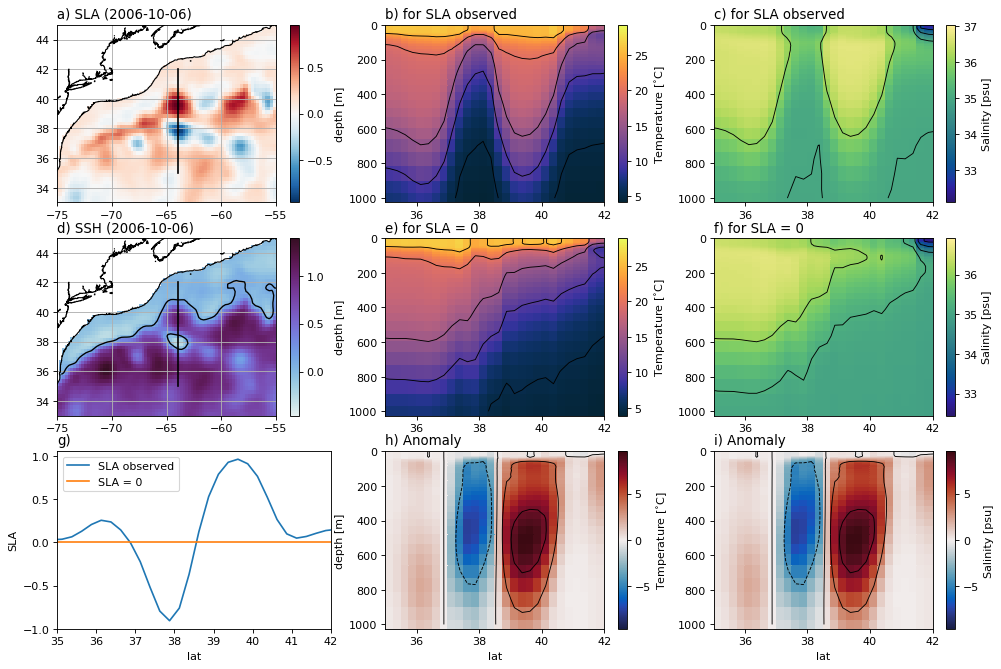

In [78]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
ds.SLA.isel(time = 5026).plot(ax = ax[0,0], cbar_kwargs={'label': ''})
ax[0,0].grid()
ax[0,0].axvline(x = -64, ymax = (42-33)/(45-33), ymin = (35-33)/(45-33),color = 'k')
ax[0,0].set_xlim([-75,-55])
ax[0,0].set_ylim([33,45])
ds_bat['bathymetry'].plot.contour(**kw,ax = ax[0,0])
ax[0,0].set_title('a) SLA (2006-10-06)', loc='left')
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('')


ds.SSH.isel(time = 5026).plot(ax = ax[1,0], cbar_kwargs={'label': ''}, center=False, cmap=cmocean.cm.dense)
ds.SSH.isel(time = 5026).plot.contour(ax = ax[1,0], colors = 'k', linewidths = 1.2, levels=np.linspace(0.4, 0.41, 1))
ax[1,0].grid()
ax[1,0].axvline(x = -64, ymax = (42-33)/(45-33), ymin = (35-33)/(45-33),color = 'k')
ax[1,0].set_xlim([-75,-55])
ax[1,0].set_ylim([33,45])
ds_bat['bathymetry'].plot.contour(**kw,ax = ax[1,0])
ax[1,0].set_title('d) SSH (2006-10-06)', loc='left')
ax[1,0].set_xlabel('')
ax[1,0].set_ylabel('')


x.SLA_ori.plot(ax = ax[2,0],label = "SLA observed")
x.SLA.plot(ax = ax[2,0],label = "SLA = 0")
ax[2,0].legend()
ax[2,0].set_xlim([35,42])
ax[2,0].set_title('g)', loc='left')
ax[2,0].set_title('')


sy.TEMP_adj.T.plot(yincrease = False,cmap = cmocean.cm.thermal,ax = ax[0,1], cbar_kwargs={'label': 'Temperature [$^{\circ}$C]'})
sy.TEMP_adj.T.plot.contour(yincrease = False,ax = ax[0,1],colors = 'k',linewidths = .8)
sy.PSAL_adj.T.plot(yincrease = False,cmap = cmocean.cm.haline,ax = ax[0,2], cbar_kwargs={'label': 'Salinity [psu]'})
sy.PSAL_adj.T.plot.contour(yincrease = False,ax = ax[0,2],colors = 'k',linewidths = .8)
ax[0,1].set_title('b) for SLA observed', loc='left')
ax[0,2].set_title('c) for SLA observed', loc='left')
ax[0,1].set_xlabel('')
ax[0,2].set_xlabel('')
ax[0,1].set_ylabel('depth [m]')
ax[0,2].set_ylabel('')

sy2.TEMP_adj.T.plot(yincrease = False,cmap = cmocean.cm.thermal,ax = ax[1,1], cbar_kwargs={'label': 'Temperature [$^{\circ}$C]'})
sy2.TEMP_adj.T.plot.contour(yincrease = False,ax = ax[1,1],colors = 'k',linewidths = .8)
sy2.PSAL_adj.T.plot(yincrease = False,cmap = cmocean.cm.haline,ax = ax[1,2], cbar_kwargs={'label': 'Salinity [psu]'})
sy2.PSAL_adj.T.plot.contour(yincrease = False,ax = ax[1,2],colors = 'k',linewidths = .8)
ax[1,1].set_xlabel('')
ax[1,2].set_xlabel('')
ax[1,1].set_title('e) for SLA = 0', loc='left')
ax[1,2].set_title('f) for SLA = 0', loc='left')
ax[1,1].set_ylabel('depth [m]')
ax[1,2].set_ylabel('')

(sy.TEMP_adj.T-sy2.TEMP_adj.T).plot(yincrease = False,cmap = cmocean.cm.balance,ax = ax[2,1], cbar_kwargs={'label': 'Temperature [$^{\circ}$C]'})
(sy.TEMP_adj.T-sy2.TEMP_adj.T).plot.contour(yincrease = False,ax = ax[2,1],colors = 'k',linewidths = .8)
(sy.TEMP_adj.T-sy2.TEMP_adj.T).plot(yincrease = False,cmap = cmocean.cm.balance,ax = ax[2,2], cbar_kwargs={'label': 'Salinity [psu]'})
(sy.TEMP_adj.T-sy2.TEMP_adj.T).plot.contour(yincrease = False,ax = ax[2,2],colors = 'k',linewidths = .8)
ax[2,1].set_title('h) Anomaly', loc='left')
ax[2,2].set_title('i) Anomaly', loc='left')
ax[2,1].set_ylabel('depth [m]')
ax[2,2].set_ylabel('')

for i in np.arange(3):
    for j in np.arange(1,3):
        ax[i,j].set_xlim([35,42])
        ax[i,j].set_title('')

plt.savefig(path_out + '/Eddy_TS.png', transparent=False)
plt.show()

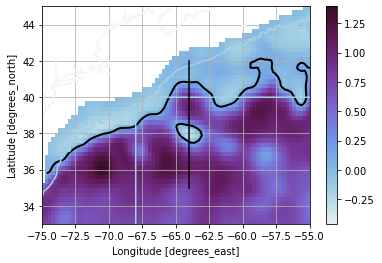

In [76]:
ds.SSH.isel(time = 5026).plot(cbar_kwargs={'label': ''}, center=False, cmap=cmocean.cm.dense)
ds.SSH.isel(time = 5026).plot.contour(colors = 'k', linewidths = 2, levels=np.linspace(0.1, 0.11, 1))
plt.grid()
plt.axvline(x = -64, ymax = (42-33)/(45-33), ymin = (35-33)/(45-33),color = 'k')
plt.xlim([-75,-55])
plt.ylim([33,45])
ds_bat['bathymetry'].plot.contour(color = 'k')